# Lab 5: time series forecast with AutoGluon

[AutoGluon](https://auto.gluon.ai/stable/index.html) is an open-source AutoML library that automates machine learning and deep learning for applications involving image, text, and tabular data. It enables users to quickly develop high-performance models with just a few lines of code by automating tasks like data preprocessing, model selection, hyperparameter tuning, and ensemble learning.

[AutoGluon Time Series](https://auto.gluon.ai/stable/tutorials/timeseries/index.html) can forecast the future values of multiple time series given the historical data and other related covariates. A single call to AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html)’s `fit()` method trains multiple models to generate accurate probabilistic forecasts, and does not require you to manually deal with cumbersome issues like model selection and hyperparameter tuning.

Under the hood, AutoGluon combines various state of the art forecasting algorithms. These include established statical methods like ETS and ARIMA from [`StatsForecast`](https://github.com/Nixtla/statsforecast), efficient tree-based forecasters like LightGBM based on [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular/index.html), flexible deep learning models like [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) and Temporal Fusion Transformer from [GluonTS](https://ts.gluon.ai/), and a pretrained zero-shot forecasting model, [Chronos](https://github.com/amazon-science/chronos-forecasting). 

This workshop features DeepAR algorithm in the notebook [lab 3](./lab3_sagemaker_deepar.ipynb) and Chronos in the notebook [lab 4](./lab4_chronos.ipynb).

AutoGluon Time Series provides a robust and easy way to use Chronos through the `TimeSeriesPredictor` API. More specifically:
- Chronos can be combined with other forecasting models to build accurate ensembles using the `"high_quality"` and `"best_quality"` presets.
- Alternatively, Chronos can be used as a standalone zero-shot model with presets such as `"chronos_small"` or `"chronos_base"`.

For the full list of available time series algorithm used in AutoGluon refer to the [Model Zoo](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html) page in the AutoGluon documentation.

This notebook demonstrate how to build time series forecast using AutoGluon Time Series API.

If you're not familiar with time series forecast, refer to [Forecasting Time Series in Depth](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html) section in the AutoGluon documentation for more details and background.

## Import packages

In [8]:
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
%pip install fsspec

  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.6.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --upgrade autogluon
# %pip uninstall -q torchaudio torchvision torchtext # fix incompatible package versions on Colab
%pip install --upgrade pip sagemaker boto3 s3fs

In [284]:
%matplotlib inline

import json
import os
import boto3
import zipfile
from time import gmtime, strftime, sleep
import datetime
import sagemaker
import numpy as np
import pandas as pd
import tqdm
import autogluon
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker, SelectMultiple
)

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [8]:
from importlib.metadata import version
print(version('autogluon'))

1.1.1


## Set literals and general variables

In [4]:
%store -r

In [9]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [10]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "autogluon-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "autogluon"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [11]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [12]:
dataset_zip_file_name = "LD2011_2014.txt.zip"
s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [15]:
os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
)

In [18]:
zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
zip_ref.extractall("./data")
zip_ref.close()
dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])

In [ ]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [19]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [20]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [21]:
# resample to 2h intervals
freq = "2H"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

/tmp/ipykernel_7845/1857560915.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_kw = df_raw.resample(freq).sum() / div
100%|██████████| 370/370 [00:00<00:00, 1779.70it/s]


In [31]:
data_kw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,2.379442,28.538407,1.954822,160.569106,67.225610,260.416667,7.560769,352.693603,75.830420,53.897849,...,439.864383,40675.0,2816.983122,3980.113636,127.933507,7.753072,504.938543,118.948247,703.445748,12033.783784
2014-12-31 18:00:00,2.220812,28.449502,2.172024,208.587398,91.310976,385.788690,12.719050,359.427609,95.498252,84.408602,...,425.053533,43300.0,2793.776371,3454.545455,105.606258,5.266238,500.877963,47.787980,706.011730,9554.054054
2014-12-31 20:00:00,2.379442,24.004267,1.737619,174.288618,89.176829,330.357143,11.447145,292.508418,84.134615,75.806452,...,330.389008,39137.5,1676.160338,1857.954545,74.967405,4.169105,420.654083,131.886477,675.219941,8344.594595
2014-12-31 22:00:00,2.062183,21.692745,1.737619,161.331301,85.365854,311.383929,11.023177,251.262626,68.181818,72.446237,...,289.079229,31775.0,1591.244726,1303.977273,46.284224,7.533645,665.605795,178.422371,669.263196,7263.513514


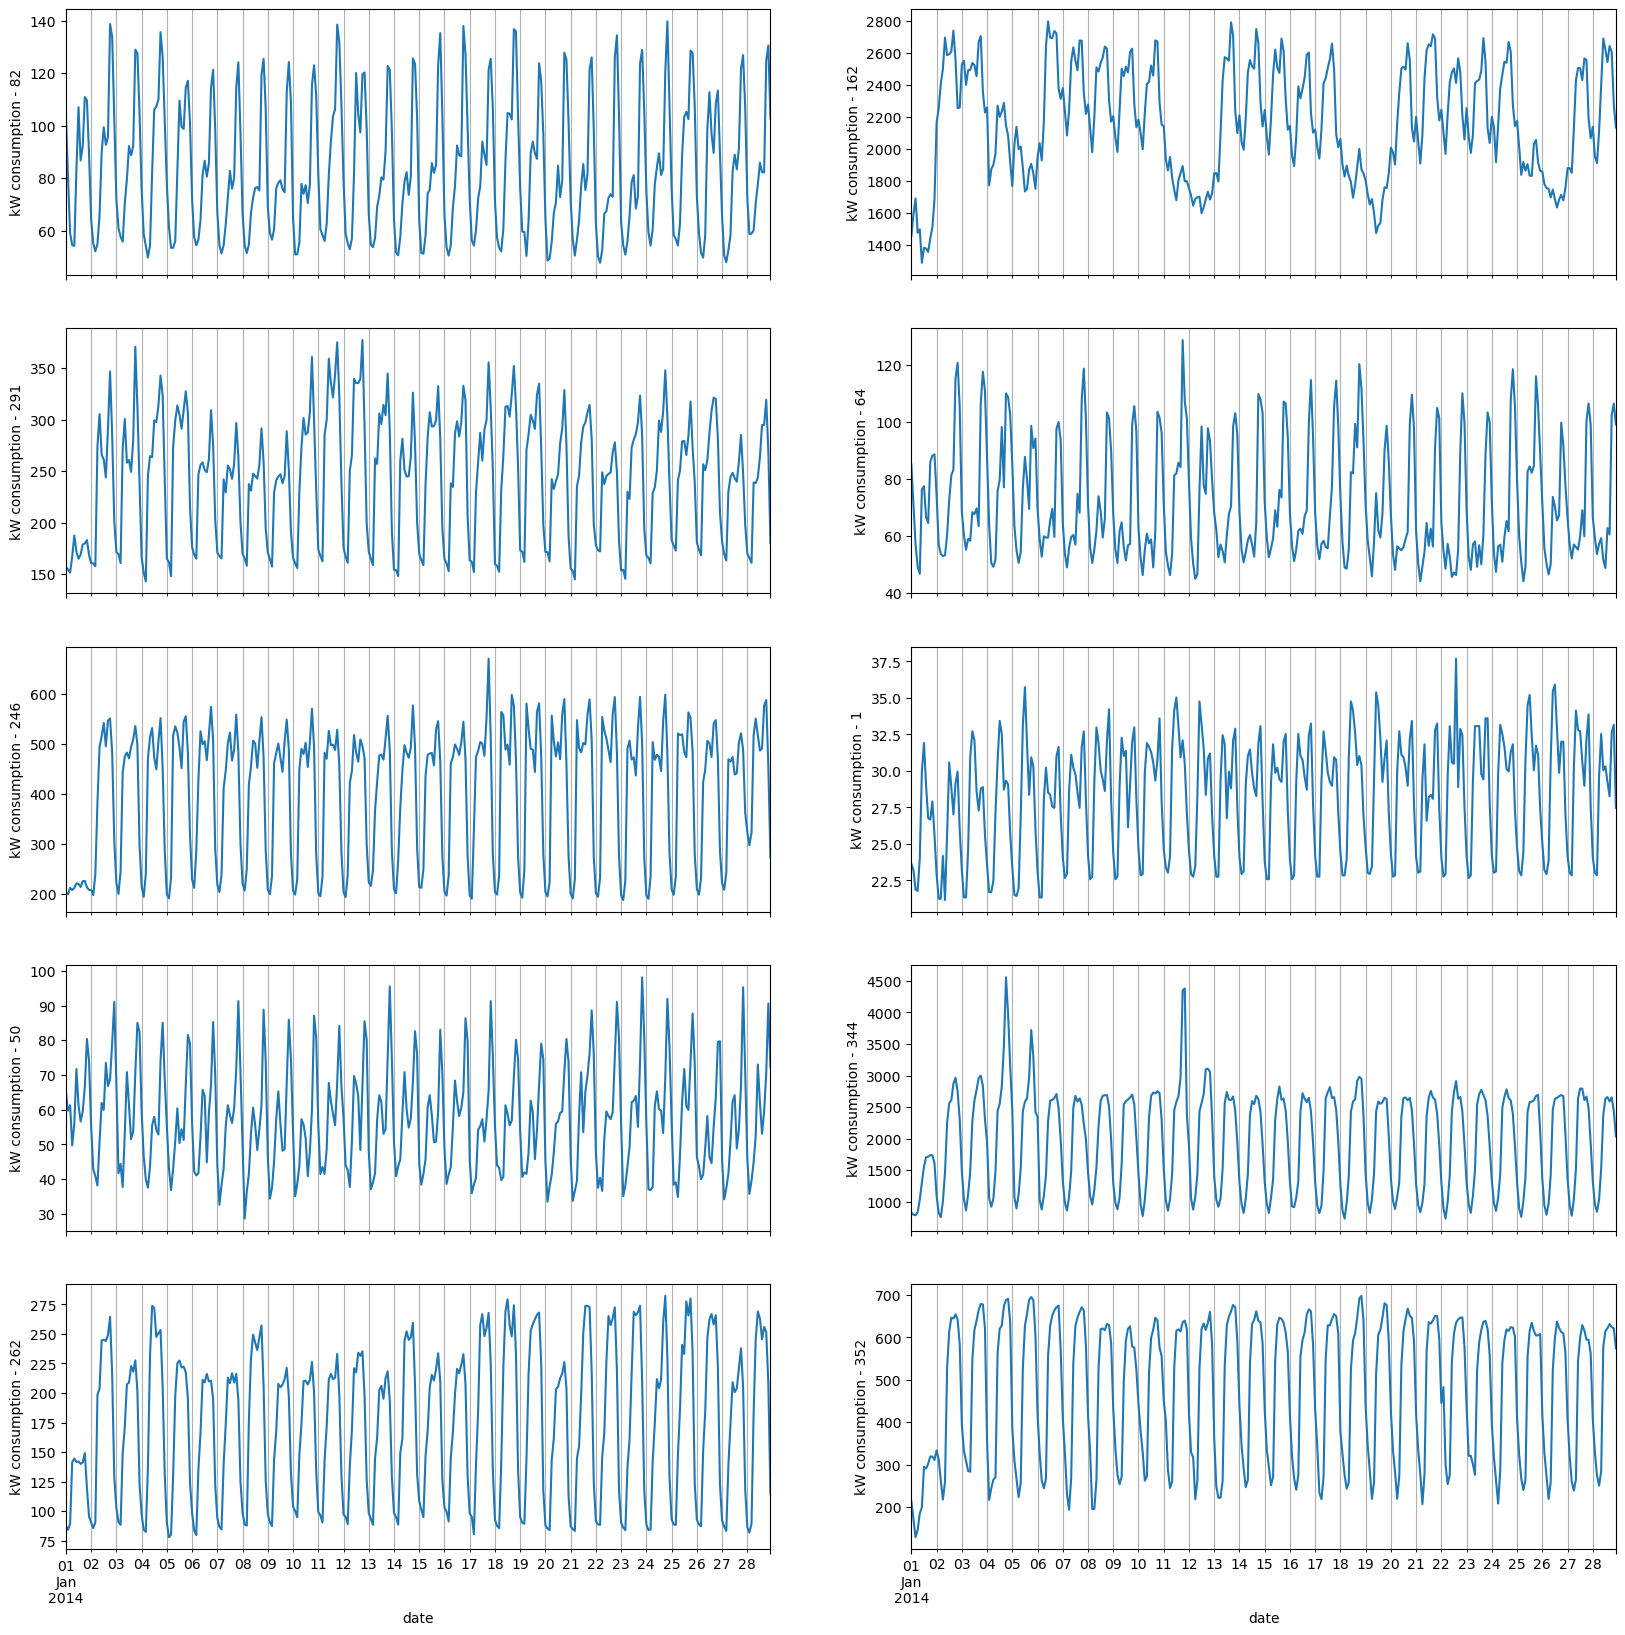

In [32]:
# show random 10 timeseries for 28 day period
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts_id in enumerate(np.random.randint(1, data_kw.shape[1], size=10).tolist()):
    timeseries[ts_id].loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts_id}")
    axx[i].grid(which="minor", axis="x")

In [404]:
# select two random time series to include in a small dataset
columns_to_keep = np.random.randint(1, data_kw.shape[1], size=2).tolist()
columns_to_keep

[99, 231]

In [59]:
data_kw_small = data_kw.iloc[:, columns_to_keep]
data_kw_small

,MT_330,MT_113
2011-01-01 00:00:00,39.446875,0.000000
2011-01-01 02:00:00,46.099219,0.000000
2011-01-01 04:00:00,44.222656,0.000000
2011-01-01 06:00:00,45.239844,0.000000
2011-01-01 08:00:00,48.602344,0.000000
...,...,...
2014-12-31 16:00:00,125.892969,38.497741
2014-12-31 18:00:00,112.316406,42.545181
2014-12-31 20:00:00,44.770312,34.544428
2014-12-31 22:00:00,38.749219,31.438253


## Train AutoGluon models

[AutoGluon Time Series - Forecasting Quick Start](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html)

In [40]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day

print(f"Sampling frequency set to {freq}. Generate predictions for {prediction_length} intervals")

Sampling frequency set to 2H. Generate predictions for 84 intervals


### Convert dataset to AutoGluon format

AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format). Each row of the data frame contains a single observation (timestep) of a single time series represented by:
- unique ID of the time series (`"item_id"`) as int or str  
- timestamp of the observation (`"timestamp"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"target"`)

Note, you can choose the names of the columns arbitrary, but need to specify the names when constructing a `TimeSeriesDataFrame` object.

<div class="alert alert-info">
A note on dataset size - TBD
</div>

In [375]:
USE_FULL_DATASET = False

In [376]:
if USE_FULL_DATASET:
    ts_wide_df = data_kw
else:
    ts_wide_df = data_kw_small

In [377]:
# Melt the DataFrame
melted_df = pd.melt(
    data_kw_small.reset_index(),
    id_vars='index', 
    value_vars=ts_wide_df.columns, 
    var_name='item_id', 
    value_name='target'
)

# Rename the 'index' column to 'timestamp'
melted_df = melted_df.rename(columns={'index': 'timestamp'})

print(melted_df)

                timestamp item_id     target
0     2011-01-01 00:00:00  MT_330  39.446875
1     2011-01-01 02:00:00  MT_330  46.099219
2     2011-01-01 04:00:00  MT_330  44.222656
3     2011-01-01 06:00:00  MT_330  45.239844
4     2011-01-01 08:00:00  MT_330  48.602344
...                   ...     ...        ...
35061 2014-12-31 16:00:00  MT_113  38.497741
35062 2014-12-31 18:00:00  MT_113  42.545181
35063 2014-12-31 20:00:00  MT_113  34.544428
35064 2014-12-31 22:00:00  MT_113  31.438253
35065 2015-01-01 00:00:00  MT_113   5.835843

[35066 rows x 3 columns]


Use the [`TimeSeriesDataFrame`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) classs to convert a Pandas DataFrame to AutoGluon time series Data Frame.

In [378]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    melted_df,
    id_column="item_id",
    timestamp_column="timestamp",
)

In [379]:
ts_df

target
item_id timestamp                     
MT_330  2011-01-01 00:00:00  39.446875
        2011-01-01 02:00:00  46.099219
        2011-01-01 04:00:00  44.222656
        2011-01-01 06:00:00  45.239844
        2011-01-01 08:00:00  48.602344
...                                ...
MT_113  2014-12-31 16:00:00  38.497741
        2014-12-31 18:00:00  42.545181
        2014-12-31 20:00:00  34.544428
        2014-12-31 22:00:00  31.438253
        2015-01-01 00:00:00   5.835843

[35066 rows x 1 columns]

Note that AutoGluon generates forecasts for each time series individually, without modeling interactions between different items/time series. 

### Split the dataset to train and test
Split the dataset. The train dataset contains the slice `[:-prediction_length]` for each time series. The test dataset contains full time series for each item.

In [380]:
train_df, test_df = ts_df.train_test_split(prediction_length)

In [381]:
train_df.tail()

target
item_id timestamp                     
MT_113  2014-12-24 16:00:00  34.920934
        2014-12-24 18:00:00  39.062500
        2014-12-24 20:00:00  31.344127
        2014-12-24 22:00:00  32.756024
        2014-12-25 00:00:00  35.109187

In [382]:
test_df.tail()

target
item_id timestamp                     
MT_113  2014-12-31 16:00:00  38.497741
        2014-12-31 18:00:00  42.545181
        2014-12-31 20:00:00  34.544428
        2014-12-31 22:00:00  31.438253
        2015-01-01 00:00:00   5.835843

### Train models

Use the AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) class to train models and do inference.

`TimeSeriesPredictor` provides probabilistic (quantile) multi-step-ahead forecasts for **univariate time series**. The forecast includes both the mean - conditional expectation of future values given the past, as well as the quantiles of the forecast distribution, indicating the range of possible future outcomes.

`TimeSeriesPredictor` fits both _global_ deep learning models that are shared across all time series such as DeepAR, Transformer, as well as _local_ statistical models that are fit to each individual time series such as ARIMA, ETS.

You can include covariates known as dynamic features, exogenous variables, additional regressors or related time series into training. Examples of such covariates include holidays, promotions or weather forecasts. See the AutoGluon documentation for more details and examples.

In [383]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
experiment_name = f"{experiment_prefix}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
eval_metric = 'WQL'
forecast_quantiles = [0.1, 0.5, 0.9]
predictor_data_path = f"{experiment_name}-{timestamp}"

In [385]:
start_dataset = test_df.index.get_level_values(1)[0]
end_dataset = test_df.index.get_level_values(1)[-1]

In [386]:
predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
    path=predictor_data_path, 
)

Now run [`fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html#autogluon.timeseries.TimeSeriesPredictor.fit) method to train models. 


You can provide a time limit in seconds in the parameter `time_limit` to fit the training in your time budget. If not provided, `fit()` will run until all models have completed training.

Use the `presets` parameter to control a trade-off between the training speed and quality of results. Depending on the parameter value, AutoGluon can train simple statistical models and fast tree-based models for short training time or use all available models plus additional statistical models for more accurate predictions but longer training time. Note that Chronos has own presents in AutoGluon.

If you're not familiar with AutoGluon, it's recommended to use `presets` and avoid specifying most other `fit()` parameters.

If not specified otherwise in the parameter `enable_ensemble`, AutoGluon will fit a weighted ensemble on top of trained models.

<div class="alert alert-info">
The training takes about XX min on a CPU-only instance <code>ml.c5.4xlarge</code> and XX min on a GPU instance <code>ml.g5.2xlarge</code>
</div>

`High_quality`  
Full dataset (370 time series, 6456130 rows):
- ml.c5.4xlarge: Total runtime: 2671.17 s
- ml.g5.2xlarge: Total runtime: 3690.43 s

Small dataset (2 time series, 34898 rows):
- ml.c5.4xlarge: Total runtime: 815.22 s 
- ml.g5.2xlarge: Total runtime: 396.90 s
- ml.g5.4xlarge: 
- ml.c7i.2xlarge:
- ml.m7i.2xlarge:
- ml.r7i.2xlarge:


RecursiveTabular, DirectTabular - longest training time

Chronos trained only on GPU-instance

In [ ]:
predictor.fit(
    train_data=train_df,
    # time_limit=30*60,
    presets="high_quality",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon-2H-2-17533-20240905-191707'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 7 16:53:32 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       20.00 GB / 30.34 GB (65.9%)
Disk Space Avail:   40.05 GB / 49.98 GB (80.1%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2h'
Provided train_data has 34898 rows, 2 time series. Median time series length is 17449 (min=17449, max=17449). 


### Working with trained predictor

After training completed, you can access all information via `TimeSeriesPredictor` class.

In [ ]:
# Detailed information about models trained
predictor.fit_summary()

In [ ]:
# Dictionary of model details
predictor.info()

See the AutoGluon documentation on the [`leaderboard()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.leaderboard.html) method for description of each shown column.

In [390]:
# Model leaderboard with scoring
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.054577,20.803942,0.757337,12
1,DirectTabular,-0.058195,0.208038,25.287084,3
2,AutoARIMA,-0.062299,16.624920,0.028047,8
3,PatchTST,-0.063447,0.023844,50.537946,11
4,TemporalFusionTransformer,-0.064850,0.039919,404.073991,9
5,SeasonalNaive,-0.066825,1.171354,0.030291,1
6,DeepAR,-0.067009,0.387658,230.289579,10
7,AutoETS,-0.067242,18.617333,0.028049,7
8,NPTS,-0.075044,1.938653,0.028269,5
9,RecursiveTabular,-0.092906,1.229052,40.854718,2


In [391]:
# You can provide a dataset to evaluate the model leaderboard based on the test data
predictor.leaderboard(test_df)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DirectTabular,-0.078908,-0.058195,0.219332,0.208038,25.287084,3
1,WeightedEnsemble,-0.088332,-0.054577,21.822490,20.803942,0.757337,12
2,PatchTST,-0.107852,-0.063447,0.040383,0.023844,50.537946,11
3,DeepAR,-0.110109,-0.067009,0.413886,0.387658,230.289579,10
4,AutoARIMA,-0.110519,-0.062299,16.149028,16.624920,0.028047,8
5,TemporalFusionTransformer,-0.114876,-0.064850,0.095665,0.039919,404.073991,9
6,NPTS,-0.127011,-0.075044,1.958971,1.938653,0.028269,5
7,RecursiveTabular,-0.151023,-0.092906,1.221265,1.229052,40.854718,2
8,SeasonalNaive,-0.158500,-0.066825,0.026638,1.171354,0.030291,1
9,DynamicOptimizedTheta,-0.174196,-0.132529,20.582465,20.518213,0.027665,6


To load all saved predictor data including the model leaderboard, logs, and the trained model you use the [`load()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.load.html) method of the `TimeSeriesPredictor` class.

In [346]:
# list all autogluon data saved to the EBS volume
!ls -dt {experiment_prefix}*/

autogluon-2H-370-17533-20240905-075933/
autogluon-2H-370-17533-20240904-212605/
autogluon-2H-370-17533-20240904-210235/


In [74]:
# uncomment if you need to load a predictor from the saved data
# predictor_data_path="autogluon-2H-370-17533-20240905-075933"
# predictor.load(predictor_data_path)

Loading predictor from path autogluon-2H-370-17533-20240905-075933


### Save the model performance to a file

In [392]:
os.makedirs("./model-performance", exist_ok=True)

In [393]:
metrics = ['WQL', 'MAPE', 'WAPE', 'RMSE', 'MASE']
# You can also specify a model name via `model` parameter
model_metrics = predictor.evaluate(
    data=test_df, 
    metrics=metrics, 
    # model="DeepAR", 
    display=True)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Evaluations on test data:
{
    "WQL": -0.08833232300668425,
    "MAPE": -0.20169674211246072,
    "WAPE": -0.12728002760632373,
    "RMSE": -11.605938431563791,
    "MASE": -3.03605083561626
}


In [394]:
model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
model_metrics_df['experiment'] = experiment_name
model_metrics_df['timestamp'] = timestamp
# AutoGluon flipps the sign of a metric, multiply by -1
model_metrics_df['value'] = model_metrics_df['value'] * (-1)
model_metrics_df = model_metrics_df[['timestamp','metric_name','value','experiment']]

In [395]:
model_metrics_df

,timestamp,metric_name,value,experiment
0,20240905-191707,WQL,0.088332,autogluon-2H-2-17533
1,20240905-191707,MAPE,0.201697,autogluon-2H-2-17533
2,20240905-191707,WAPE,0.127280,autogluon-2H-2-17533
3,20240905-191707,RMSE,11.605938,autogluon-2H-2-17533
4,20240905-191707,MASE,3.036051,autogluon-2H-2-17533


In [396]:
model_metrics_df.to_csv(f'./model-performance/{experiment_name}-{timestamp}.csv', index=False)

### Visualize predictions

To generate predictions and to plot the results you use the methonds [`predict()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.predict.html) and [`plot()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.plot.html) of the `TimeSeriesPredictor`.

In [397]:
# persist models in memory for reduced inference latency
predictor.persist()

['AutoETS',
 'TemporalFusionTransformer',
 'WeightedEnsemble',
 'NPTS',
 'DirectTabular']

In [398]:
prediction_df = predictor.predict(test_df)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


`predict()` method generates `prediction_length` starting from the end of the provided time series:

In [399]:
prediction_df

mean        0.1        0.5         0.9
item_id timestamp                                                       
MT_330  2015-01-01 02:00:00  39.300851  34.111171  39.226296   50.004789
        2015-01-01 04:00:00  39.580092  34.071289  39.518193   51.528527
        2015-01-01 06:00:00  50.332137  43.039318  50.494008   73.115777
        2015-01-01 08:00:00  66.788068  47.464101  66.973977   85.046779
        2015-01-01 10:00:00  87.076487  58.879845  86.653103  114.119930
...                                ...        ...        ...         ...
MT_113  2015-01-07 16:00:00  33.353836  28.776213  33.392293   42.240713
        2015-01-07 18:00:00  35.059149  30.850818  34.945874   44.494513
        2015-01-07 20:00:00  31.648777  27.729098  31.622206   39.116958
        2015-01-07 22:00:00  29.561340  25.044393  29.322904   37.293251
        2015-01-08 00:00:00  20.244461  17.273869  20.123845   26.851024

[168 rows x 4 columns]

`plot()` method plots predictions together with historical time series and confidence interval based on forecast quantiles.

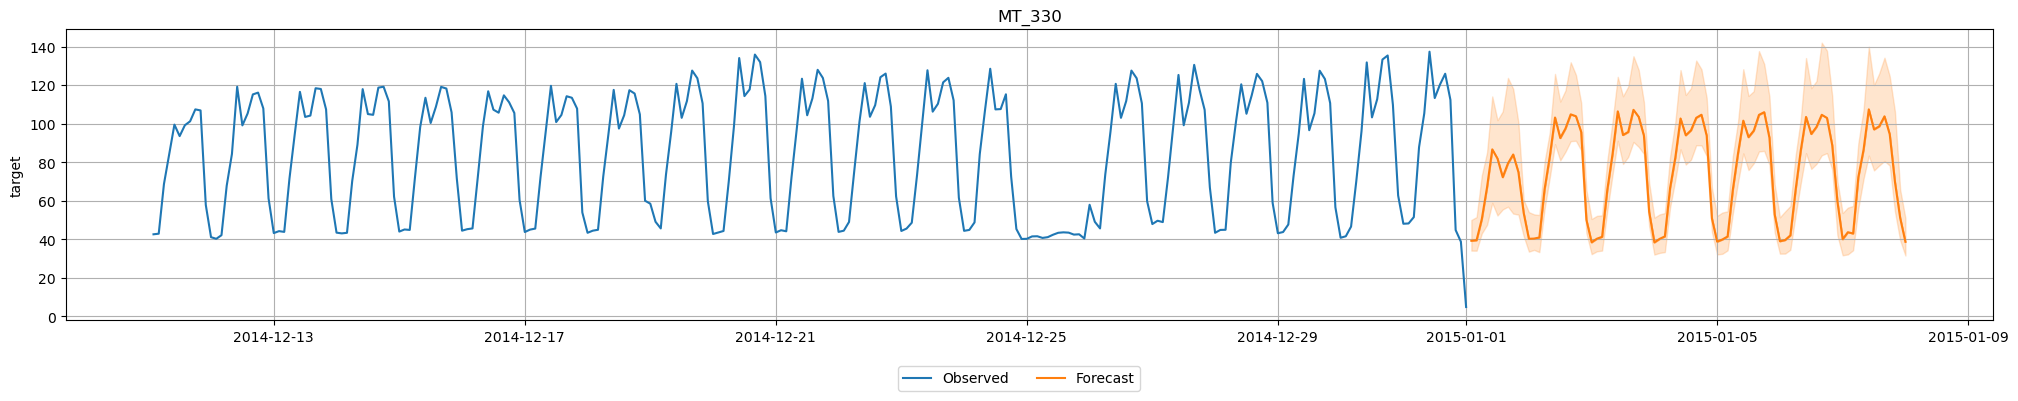

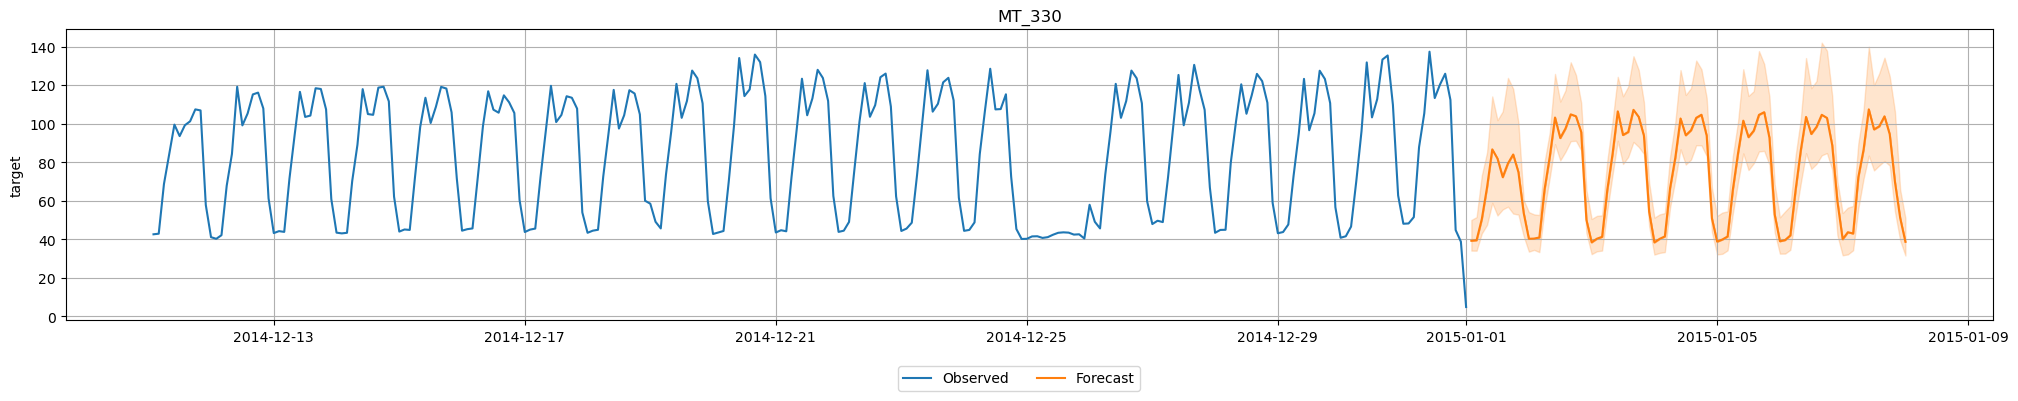

In [400]:
predictor.plot(
    data=test_df,
    predictions=prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=[prediction_df.index.get_level_values(0).unique().to_list()[0]],
    max_history_length=prediction_length*3,   
)

Experiment with different trained models and prediction dates to generate forecast. You can change the following parameters:

- `Model`: select any model from the predictor's leaderboard
- `Time series ids`: id of the time series to forecast. You can select multiple time series to plot together
- `Offset days`: how many days back from the data end the prediction starts
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history series

In [401]:
style = {"description_width": "initial"}
ts_id_list = test_df.index.get_level_values(0).unique().to_list()

In [402]:
@interact_manual(
    model=Dropdown(options=predictor.leaderboard()['model'].to_list(), description='Model:'),
    ts_ids=SelectMultiple(options=ts_id_list,value=[ts_id_list[0]], style=style, description='Time series ids:'),
    offset_days=IntSlider(min=-365, max=0, value=0, style=style, description='Offset days:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    continuous_update=False,
)
def plot_interact(
    model,
    ts_ids,
    offset_days,
    history_length,
):
    offset = -offset_days * intervals_per_day + 1
    data_end_index = offset - prediction_length + 1

    data_df = test_df.slice_by_timestep(end_index=-data_end_index) if offset > prediction_length else test_df
    inference_df = test_df.slice_by_timestep(end_index=-offset)
    prediction_df = predictor.predict(data=inference_df, model=model)
        
    predictor.plot(
        data=data_df,
        predictions=prediction_df,
        quantile_levels=forecast_quantiles,
        item_ids=list(ts_ids),
        max_history_length=history_length*prediction_length,   
    )

    plt.show()

interactive(children=(Dropdown(description='Model:', options=('WeightedEnsemble', 'DirectTabular', 'AutoARIMA'…

## Optional: use Chronos with AutoGluon

Chronos is available in 5 model sizes with different numbers of parameters: `tiny` (8M), `mini` (20M), `small` (46M), `base` (200M), and `large` (710M). Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS.
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where expensive computation happens during inference. Differently from statistical models, however, computation in the larger Chronos models requires an accelerator chip to run in a reasonable amount of time.

The easiest way to get started with Chronos is through model-specific presets available in the `TimeSeriesPredictor`. As of v1.1, the `TimeSeriesPredictor.fit` method has a separate Chronos preset for each model size, such as `"chronos_small"` or `"chronos_base"`.

Alternatively, Chronos can be combined with other time series models using presets `"chronos_ensemble"`, `"chronos_large_ensemble"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

Note that the model sizes `small` and higher require a GPU to run. However, models `tiny` and `mini` can be run on the CPU as well.


Let's work with a subset of the M4 competition data set to see Chronos-tiny in action.

In [ ]:
data = TimeSeriesDataFrame(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_tiny/train.csv"
)
data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [ ]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240416_084300'
=================== System Info ===================
AutoGluon Version:  1.1.0b20240415
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 26 20:11:48 UTC 2024
CPU Count:          32
GPU Count:          4
Memory Avail:       221.73 GB / 239.85 GB (92.4%)
Disk Space Avail:   104.55 GB / 984.21 GB (10.6%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 13520 rows, 20 time s

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


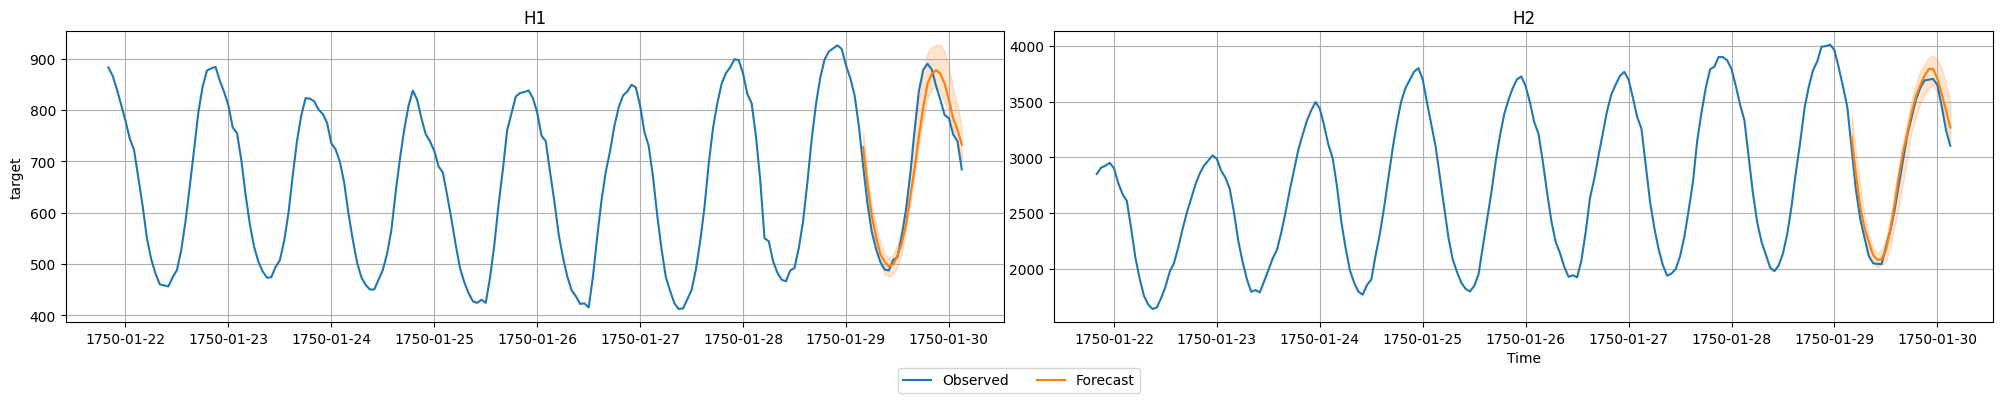

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=["H1", "H2"],
    max_history_length=200,
);

## Configuring for Performance

Looks good! As with all large deep learning models, however, some fine-grained control of inference parameters can be needed to both optimize the speed and avoid out-of-memory issues on specific hardware. For this, we will need to dive a bit deeper, configuring `hyperparameters` of the `TimeSeriesPredictor` directly.

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [ ]:
%%time
predictions = predictor.predict(train_data)

CPU times: user 2min 4s, sys: 42.4 s, total: 2min 47s
Wall time: 11.2 s


Above, we used the following configuration options for the `TimeSeriesPredictor`:
- we set `skip_model_selection=True` to skip running backtests during `fit`, as we will only consider a single model.
- in the `hyperparameters` for the Chronos model,
    - `model_path` allows us to change the model size or select different pretrained weights. This parameter can be a model string like `tiny` or `base`, a Hugging Face path like `amazon/chronos-t5-mini`, or a path to a local folder with custom weights.
    - `batch_size` configures the number of time series for which predictions are generated in parallel.
    - `device` instructs Chronos to run the model on CPU.

As we see, inference speed is slower on the CPU compared to the GPU, taking about 400ms per time series.
To overcome this limitation, AutoGluon implementation of Chronos supports several deep learning compilers that can optimize model performance on CPUs.

For example, we can set `optimization_strategy="openvino"` to use the [OpenVINO](https://github.com/openvinotoolkit/openvino) compiler for Intel CPUs to speed up Chronos inference. Behind the scenes, AutoGluon will use Hugging Face [optimum](https://github.com/huggingface/optimum-intel) for this conversion.

Note that this requires installing the optional OpenVINO dependency for AG-TS.

In [ ]:
!pip install -q "autogluon.timeseries[chronos-openvino]"

To speed up the inference even further, we can `persist` the model after calling `fit`. The `TimeSeriesPredictor.persist` method tells AutoGluon to keep the Chronos model in device memory for fast, on-demand inference instead of loading the model from disk each time.

In [ ]:
%%capture
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)
predictor.persist()

In [ ]:
%%time
predictions = predictor.predict(train_data)

CPU times: user 1min 8s, sys: 9.19 s, total: 1min 17s
Wall time: 2.9 s


That reduced the inference time by ~3x!

We could have also used the ONNX runtime by providing `optimization_strategy="onnx"`. For a discussion of these and other hyperparameters of Chronos, see the Chronos model [documentation](forecasting-model-zoo.md).

---

## Clean up

In [ ]:
# free memory
predictor.unpersist()

## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>